In [1]:
# loading libraries

library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

set.seed(19)

options(repr.matrix.max.rows = 7)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
## reading data (from https://www.ultimatetennisstatistics.com/)

tennis_data <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")
tennis_data

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23 (14-03-1996),Netherlands,Left-handed,Wikipedia,495 (60),342 (05-08-2019),Gijs Brouwer,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [3]:
## organizing/tidying data

colnames(tennis_data) = make.names(colnames(tennis_data))

tennis <- tennis_data |>
            select(Current.Rank, Age, Height, Weight, Plays, Backhand, Favorite.Surface) |> # select relevant variables
            mutate(across(everything(), function(col) {gsub(" .*", "", col)})) |> # format cells
            mutate(across(Current.Rank:Weight, as.numeric)) |> # convert chr to dbl
            mutate(across(Plays:Favorite.Surface, as.factor)) # convert chr to fct
            # drop_na()
      
tennis

Current.Rank,Age,Height,Weight,Plays,Backhand,Favorite.Surface
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
378,26,NA,NA,Right-handed,NA,NA
326,18,NA,NA,Left-handed,Two-handed,NA
178,32,185,NA,Right-handed,Two-handed,Fast
236,21,NA,NA,Right-handed,Two-handed,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮
495,23,NA,NA,Left-handed,NA,NA
419,24,NA,NA,NA,NA,NA
451,22,NA,NA,Left-handed,Two-handed,NA


In [4]:
# split data for later assessment purposes

tennis_split <- initial_split(tennis, prop = 0.75, strata = Current.Rank)

tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

In [5]:
## exploratory data analysis

# calculating missing percentages

missing_num <- tennis_training |>
                select(where(is.numeric)) |>
                pivot_longer(everything(), names_to = "var", values_to = "val") |>
                mutate(missing = is.na(val)) |>
                group_by(var, missing) |>
                summarise(n = n()) |>
                mutate(percentage_missing = (n / nrow(tennis)) * 100)

missing_fct <- tennis_training |>
                select(where(is.factor)) |>
                pivot_longer(everything(), names_to = "var", values_to = "val") |>
                mutate(missing = is.na(val)) |>
                group_by(var, missing) |>
                summarise(n = n()) |>
                mutate(percentage_missing = n / nrow(tennis) * 100)

missing_all <- bind_rows(missing_num, missing_fct) |>
                filter(missing) |>
                select(var, percentage_missing)

# summary statistics

summary_num <- tennis_training |>
                select(where(is.numeric)) |>
                summarize_all(mean, na.rm = TRUE)

find_mode <- function(v) # calculates mode of given vector
{
    tibble(var = v, y = 0) |>
        na.omit() |>
        group_by(var) |>
        summarize(n = n()) |>
        slice_max(n) |>
        select(var) |>
        pull()
}

summary_fct <- tennis_training |>
                select(where(is.factor)) |>
                summarize_all(find_mode)

summary_all <- bind_cols(summary_num, summary_fct)

missing_all # shows percentage of missing values for each variable (some have very high % missing)
summary_all # shows summary statistics for each variable; means of numeric, modes of factors

`summarise()` has grouped output by 'var'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'var'. You can override using the `.groups`
argument.


var,percentage_missing
<chr>,<dbl>
Age,0.2
Current.Rank,0.6
Height,59.0
Weight,72.6
Backhand,14.0
Favorite.Surface,38.8
Plays,7.2


Current.Rank,Age,Height,Weight,Plays,Backhand,Favorite.Surface
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
249.0674,25.83646,186.443,83.45455,Right-handed,Two-handed,Clay


In [6]:
## data visualization

# defining variables/functions

point_alpha <- 0.6
point_size <- 2.5

theme_layer <- theme(text = element_text(size = 20))

set_size <- function(p)
{
    switch(
        p,
        "age" = options(repr.plot.width = 8, repr.plot.height = 7),
        "height" = options(repr.plot.width = 7, repr.plot.height = 6),
        "weight" = options(repr.plot.width = 6, repr.plot.height = 5),
    )
}

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 306 rows containing missing values (geom_point).”


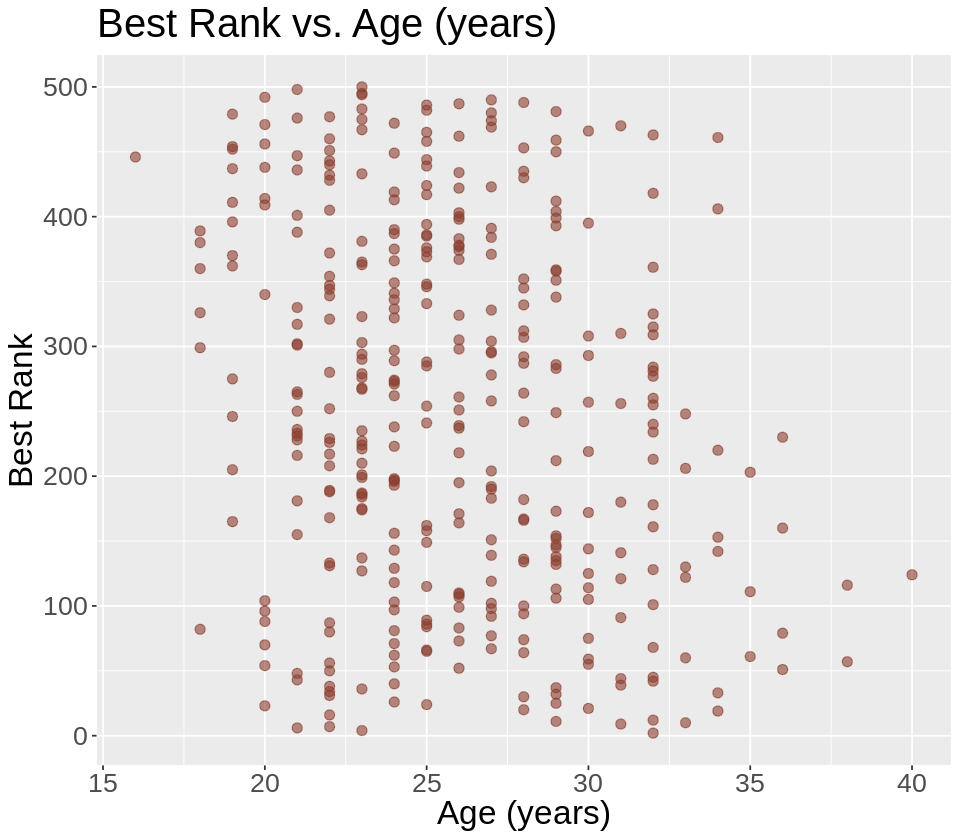

Warning message:
“Removed 371 rows containing missing values (geom_point).”


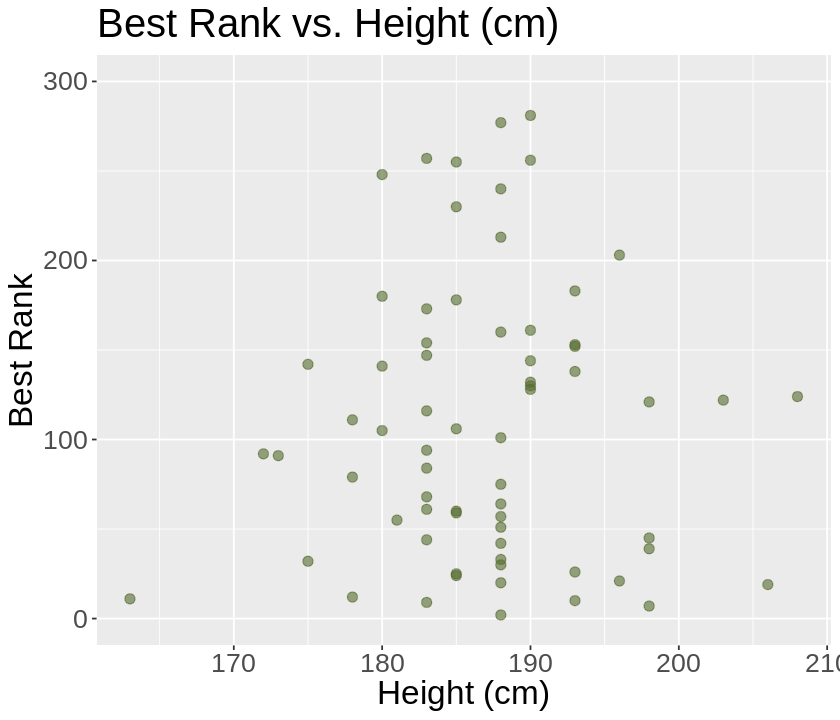

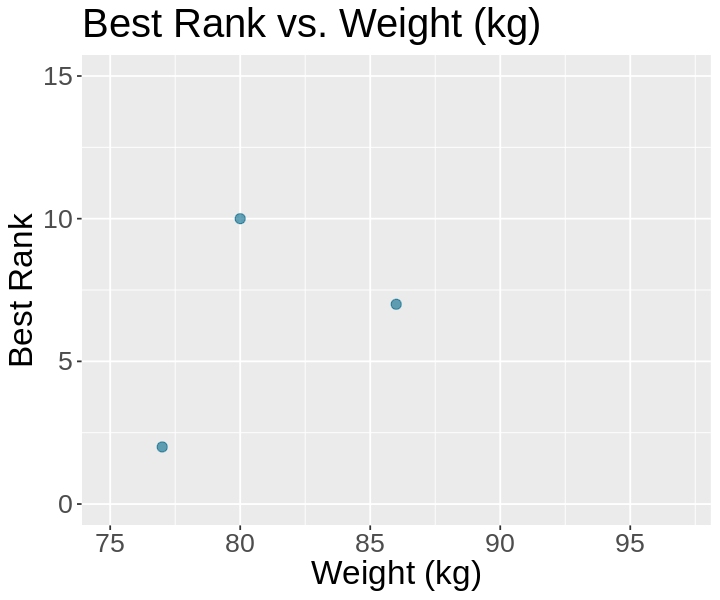

In [7]:
# plotting variables of interest against current rank

age_plot <- tennis_training |>
                ggplot(aes(x = Age, y = Current.Rank)) +
                geom_point(alpha = point_alpha, colour = "coral4", size = point_size) +
                labs(x = "Age (years)", y = "Current Rank") +
                ggtitle("Current Rank vs. Age (years)") +
                theme_layer

height_plot <- tennis_training |>
                ggplot(aes(x = Height, y = Current.Rank)) +
                geom_point(alpha = point_alpha, colour = "darkolivegreen", size = point_size) +
                ylim(0, 300) +
                labs(x = "Height (cm)", y = "Current Rank") +
                ggtitle("Current Rank vs. Height (cm)") +
                theme_layer

weight_plot <- tennis_training |>
                ggplot(aes(x = Weight, y = Current.Rank)) +
                geom_point(alpha = point_alpha, colour = "deepskyblue4", size = point_size) +
                ylim(0, 15) +
                labs(x = "Weight (kg)", y = "Current Rank") +
                ggtitle("Current Rank vs. Weight (kg)") +
                theme_layer

set_size("age")
age_plot
set_size("height")
height_plot
set_size("weight")
weight_plot

The current rank vs age plot seems to show a weak negative relationship. <br>
The current rank vs height plot loosely takes on the shape of a normal distribution. <br>
The current rank vs weight plot, with very few data points, displays no relationship.

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 306 rows containing missing values (geom_point).”


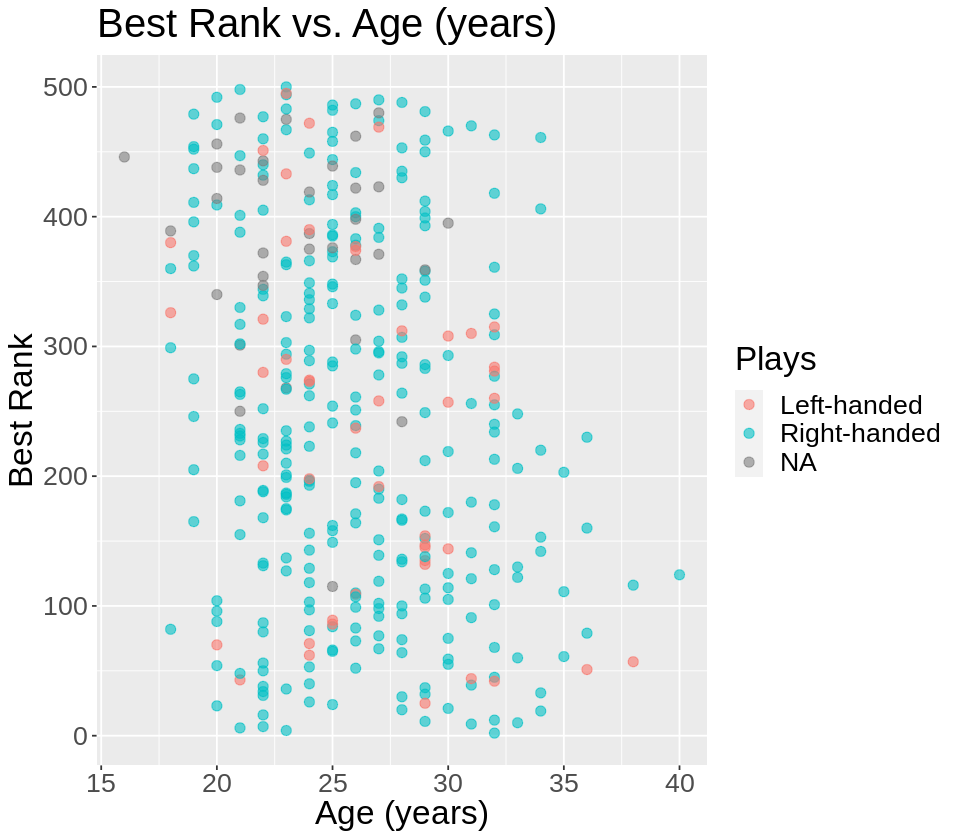

Warning message:
“Removed 371 rows containing missing values (geom_point).”


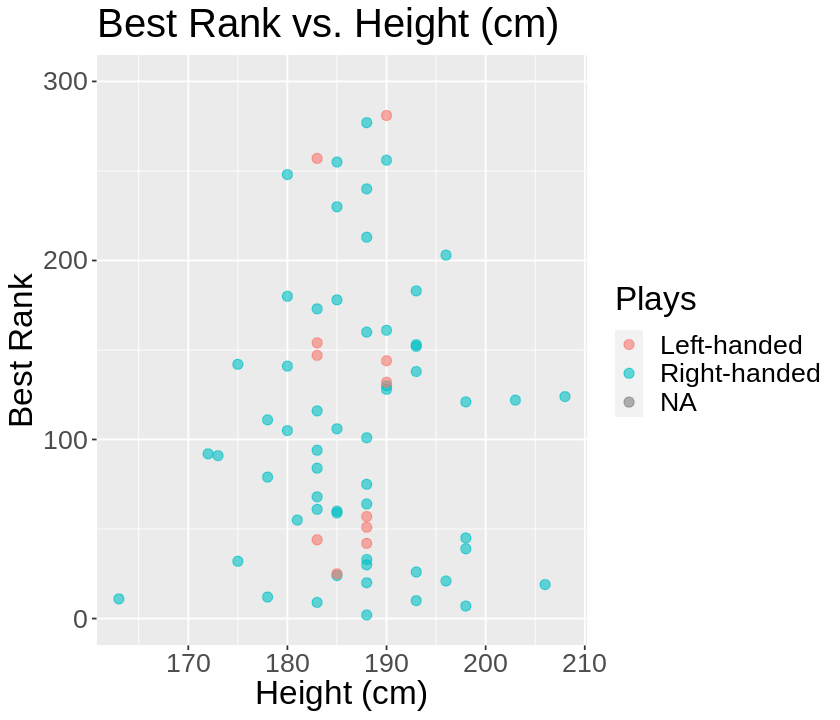

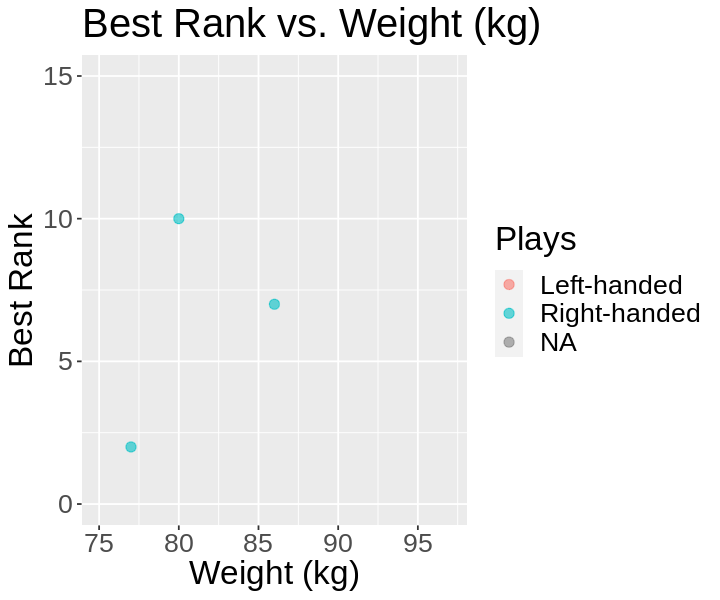

In [8]:
# colouring by handedness

age_plot_c_p <- tennis_training |>
                ggplot(aes(x = Age, y = Current.Rank, colour = Plays)) +
                geom_point(alpha = point_alpha, size = point_size) +
                labs(x = "Age (years)", y = "Current Rank") +
                ggtitle("Current Rank vs. Age (years)") +
                theme_layer

height_plot_c_p <- tennis_training |>
                ggplot(aes(x = Height, y = Current.Rank, colour = Plays)) +
                geom_point(alpha = point_alpha, size = point_size) +
                ylim(0, 300) +
                labs(x = "Height (cm)", y = "Current Rank") +
                ggtitle("Current Rank vs. Height (cm)") +
                theme_layer

weight_plot_c_p <- tennis_training |>
                ggplot(aes(x = Weight, y = Current.Rank, colour = Plays)) +
                geom_point(alpha = point_alpha, size = point_size) +
                ylim(0, 15) +
                labs(x = "Weight (kg)", y = "Current Rank") +
                ggtitle("Current Rank vs. Weight (kg)") +
                theme_layer

set_size("age")
age_plot_c_p
set_size("height")
height_plot_c_p
set_size("weight")
weight_plot_c_p

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 306 rows containing missing values (geom_point).”


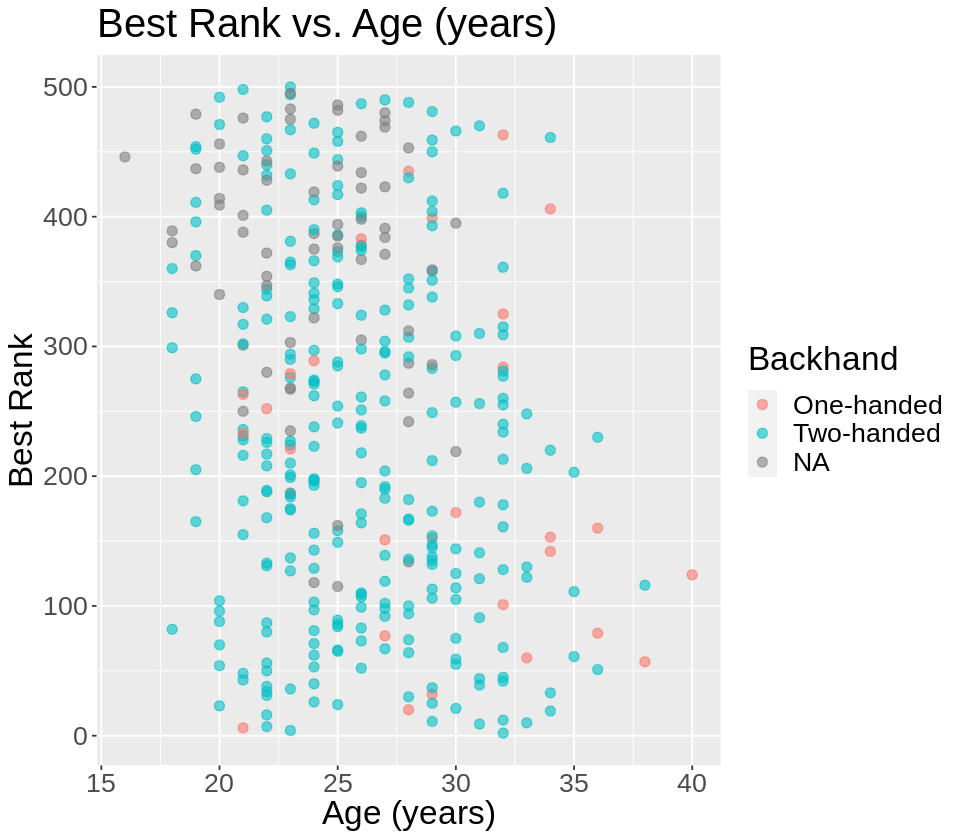

Warning message:
“Removed 371 rows containing missing values (geom_point).”


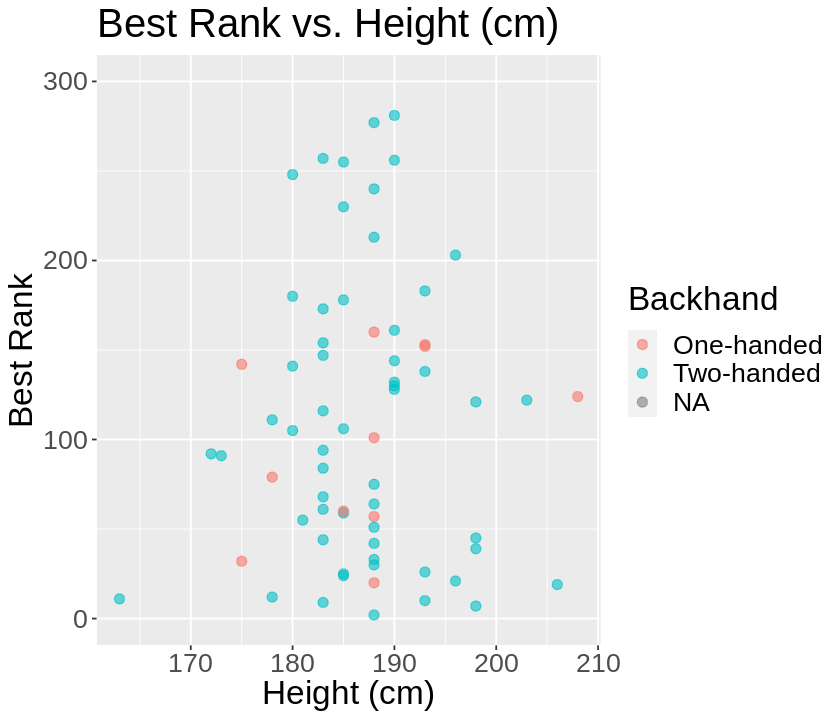

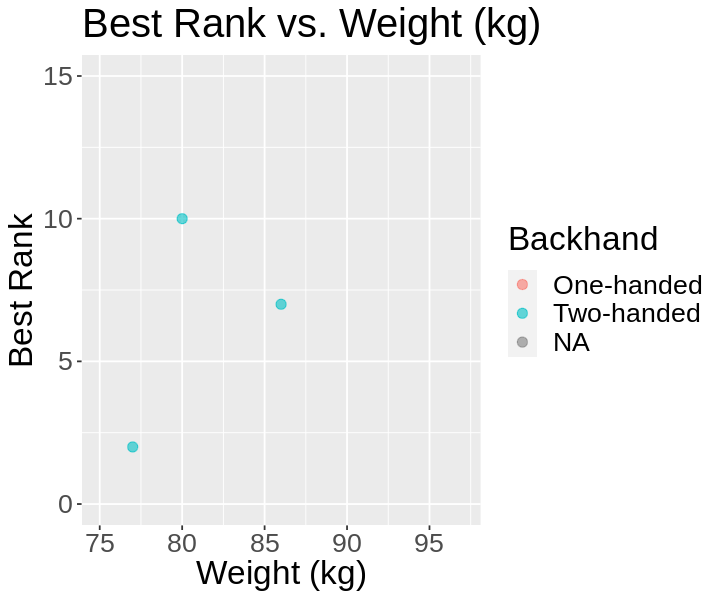

In [9]:
# colouring by backhand

age_plot_c_bh <- tennis_training |>
                ggplot(aes(x = Age, y = Current.Rank, colour = Backhand)) +
                geom_point(alpha = point_alpha, size = point_size) +
                labs(x = "Age (years)", y = "Current Rank") +
                ggtitle("Current Rank vs. Age (years)") +
                theme_layer

height_plot_c_bh <- tennis_training |>
                ggplot(aes(x = Height, y = Current.Rank, colour = Backhand)) +
                geom_point(alpha = point_alpha, size = point_size) +
                ylim(0, 300) +
                labs(x = "Height (cm)", y = "Current Rank") +
                ggtitle("Current Rank vs. Height (cm)") +
                theme_layer

weight_plot_c_bh <- tennis_training |>
                ggplot(aes(x = Weight, y = Current.Rank, colour = Backhand)) +
                geom_point(alpha = point_alpha, size = point_size) +
                ylim(0, 15) +
                labs(x = "Weight (kg)", y = "Current Rank") +
                ggtitle("Current Rank vs. Weight (kg)") +
                theme_layer

set_size("age")
age_plot_c_bh
set_size("height")
height_plot_c_bh
set_size("weight")
weight_plot_c_bh

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 306 rows containing missing values (geom_point).”


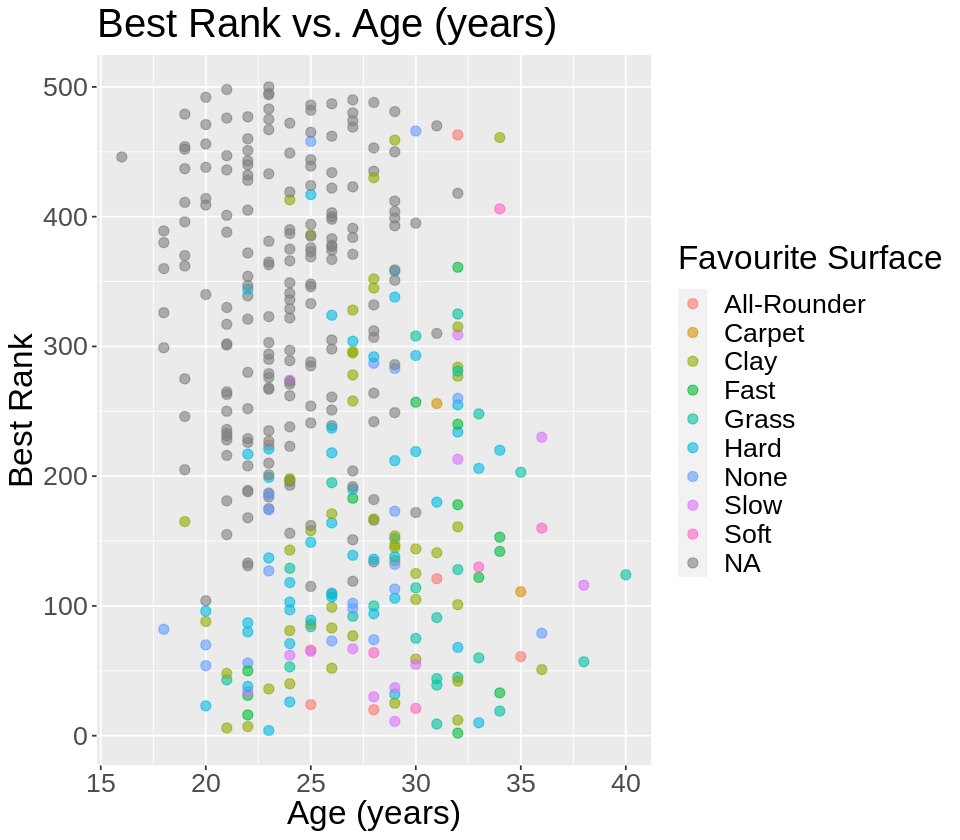

Warning message:
“Removed 371 rows containing missing values (geom_point).”


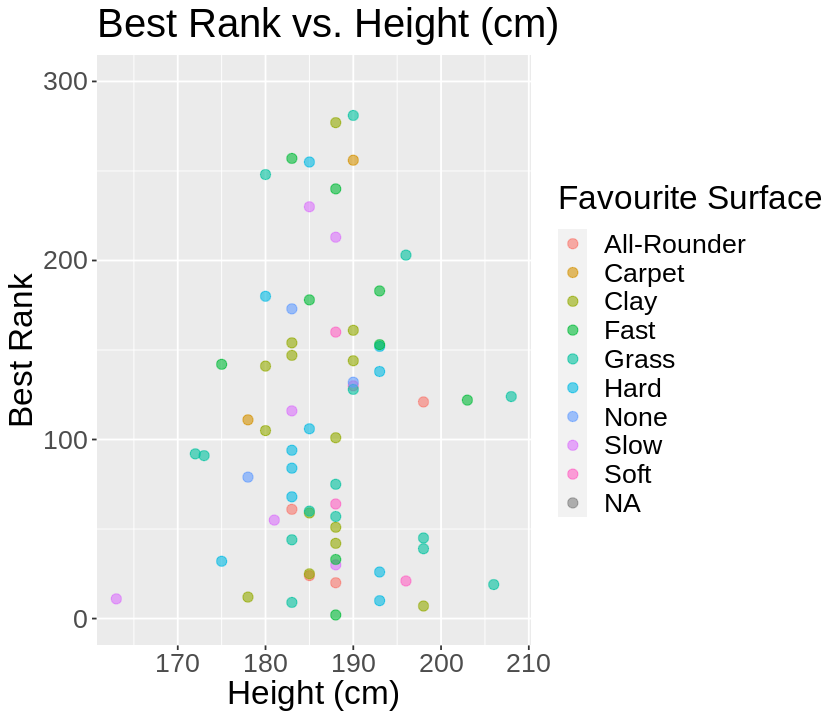

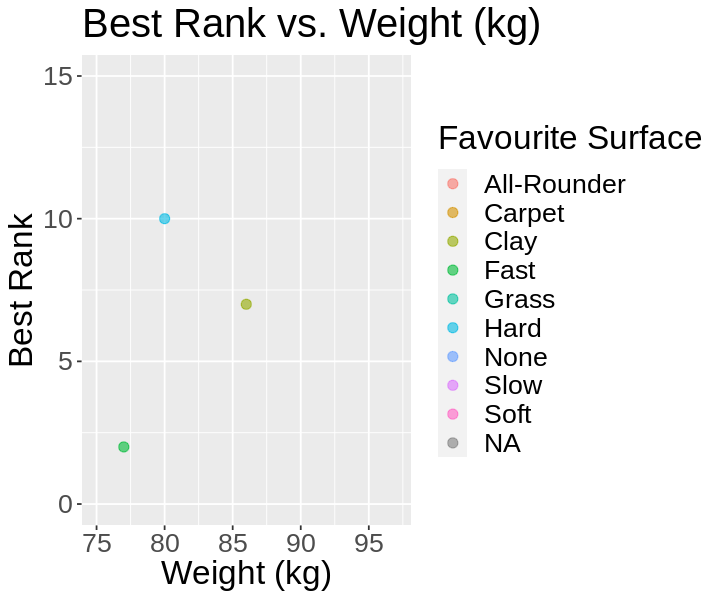

In [10]:
# colouring by favourite surface

age_plot_c_fs <- tennis_training |>
                ggplot(aes(x = Age, y = Current.Rank, colour = Favorite.Surface)) +
                geom_point(alpha = point_alpha, size = point_size) +
                labs(x = "Age (years)", y = "Current Rank", colour = "Favourite Surface") +
                ggtitle("Current Rank vs. Age (years)") +
                theme_layer

height_plot_c_fs <- tennis_training |>
                ggplot(aes(x = Height, y = Current.Rank, colour = Favorite.Surface)) +
                geom_point(alpha = point_alpha, size = point_size) +
                ylim(0, 300) +
                labs(x = "Height (cm)", y = "Current Rank", colour = "Favourite Surface") +
                ggtitle("Current Rank vs. Height (cm)") +
                theme_layer

weight_plot_c_fs <- tennis_training |>
                ggplot(aes(x = Weight, y = Current.Rank, colour = Favorite.Surface)) +
                geom_point(alpha = point_alpha, size = point_size) +
                ylim(0, 15) +
                labs(x = "Weight (kg)", y = "Current Rank", colour = "Favourite Surface") +
                ggtitle("Current Rank vs. Weight (kg)") +
                theme_layer

set_size("age")
age_plot_c_fs
set_size("height")
height_plot_c_fs
set_size("weight")
weight_plot_c_fs

Analyzing the coloured plots, there does not seem to be any correlation between best rank and handedness, backhand, or favourite surface.